In [1]:
from skeleton import *
from coco import KeyPoint
import matplotlib.pyplot as plt 
from model import *
import numpy as np
from PostProcess import PostProcess

In [2]:
coco = Coco()
coco.load_annotations()

In [3]:
metadata_image = coco.get_metadata(6)
skeleton = Skeleton(
    img_shape=metadata_image['shape'],
    skeleton=metadata_image['skeleton'],
    keypoints=metadata_image['keypoints'],
    bbox=metadata_image['bbox'],
)
skeleton.sigma = 5
skeleton.debug = False

In [4]:
net = Net()
net.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu'))['model'])
image = transforms.ToTensor()(Image.open(metadata_image['path']))

Using cache found in /home/brage/.cache/torch/hub/pytorch_vision_v0.10.0


In [5]:
if False:
    trainer = Trainer(net)
    trainer.single_step(
        image.reshape((1, ) + image.shape), 
        skeleton.confidence_map(),
        skeleton.paf_field(),
        get_annotation=lambda x: skeleton.annotation_map(x),
    )

In [6]:
confidence, paf = net(image.reshape((1, ) + image.shape))
keypoints = confidence.shape[1]

predicted_confidence, predicted_paf = PostProcess().process(confidence, paf)

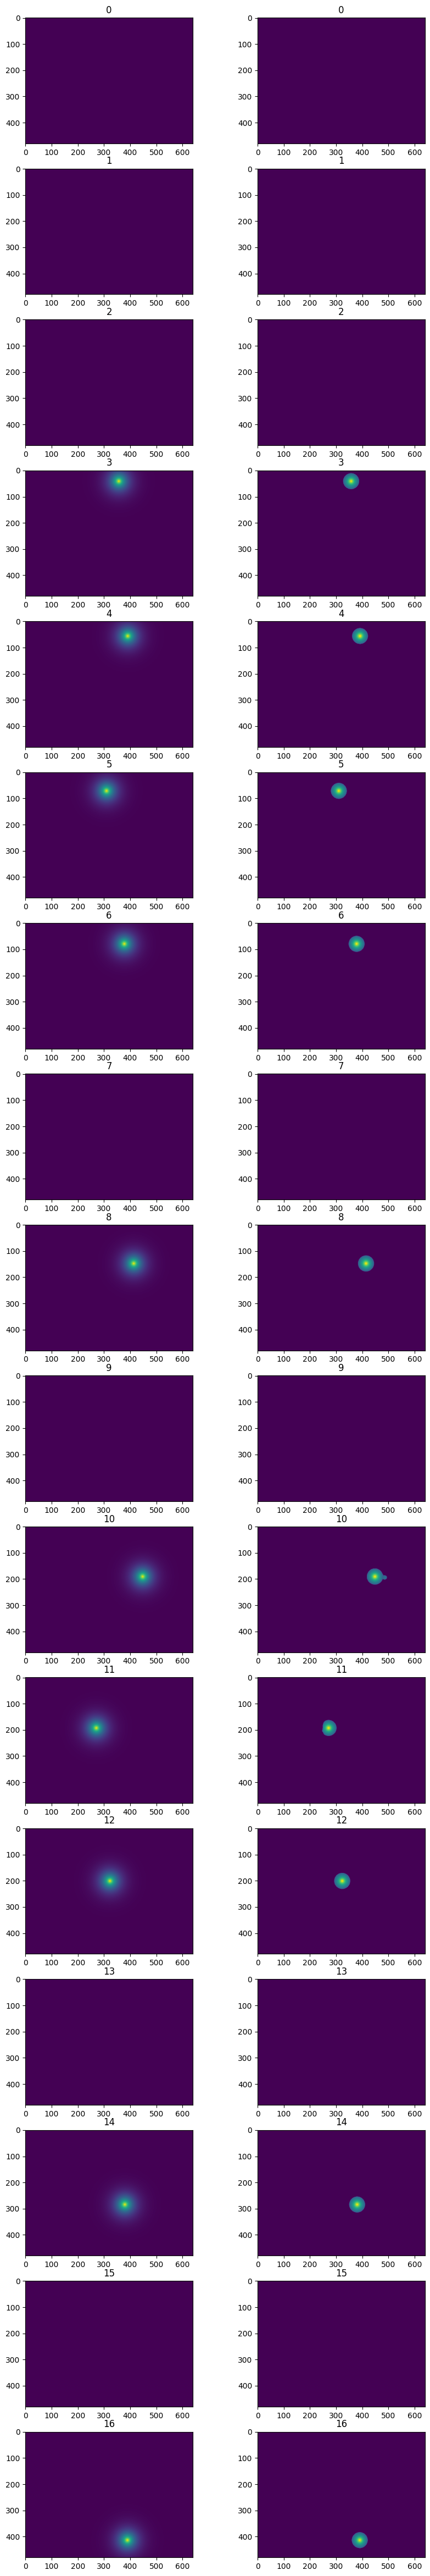

In [7]:
_, axarr = plt.subplots(keypoints, 2, figsize=(10,60))

for i in range(keypoints):
    axarr[i][0].set_title(str(i))
    axarr[i][1].set_title(str(i))
    axarr[i][0].imshow(skeleton.confidence_map()[i])
    axarr[i][1].imshow(predicted_confidence[i].detach().numpy())

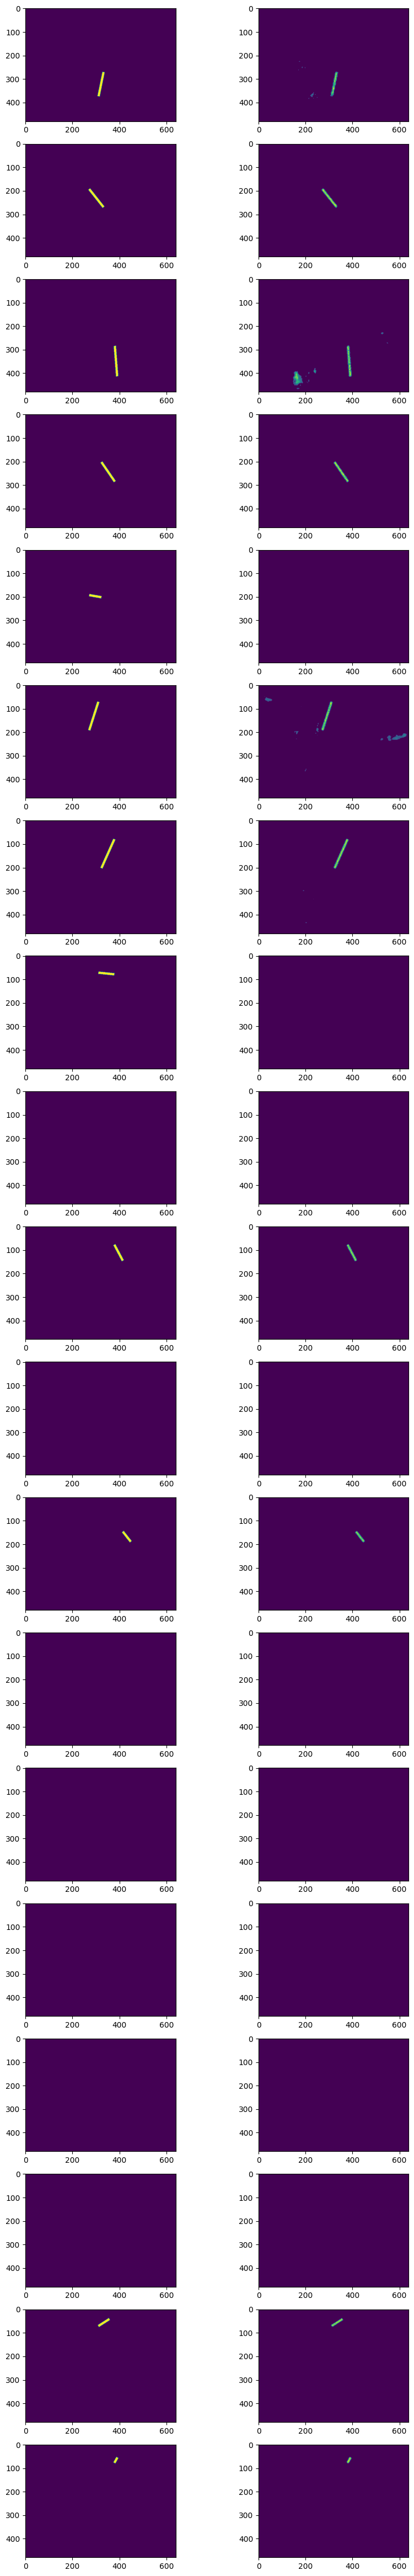

In [9]:
paf_points = paf.shape[1] // 2
_, axarr = plt.subplots(paf_points, 2, figsize=(10,60))

for limb in range(paf_points):
    limb_predicted_paf = predicted_paf[limb]
    limb_predicted_paf = ((torch.abs(limb_predicted_paf)))[:, :, 0].float()
    
    truth_paf = skeleton.paf_field()
    truth_paf = ((truth_paf[limb] != 0) * 1)[:, :, 0].float().reshape((1, ) + metadata_image['shape'])


    axarr[limb][0].imshow(truth_paf[0])
    axarr[limb][1].imshow(limb_predicted_paf)

Need to fix the mapping

## Keypoints from model

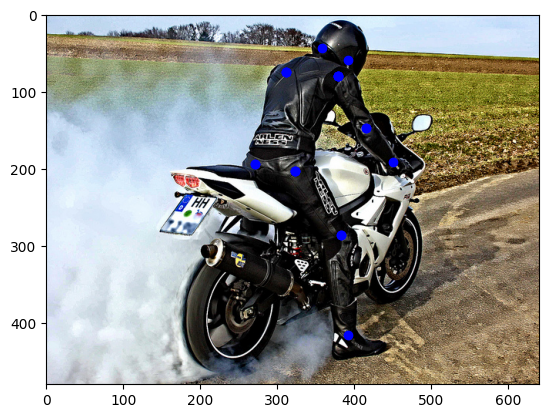

In [10]:
items = list(skeleton.merge(
    predicted_confidence, 
    predicted_paf,
))
coco.results[6].plot_image_skeleton_keypoints(items, draw_skeleton=False)

## True keypoints

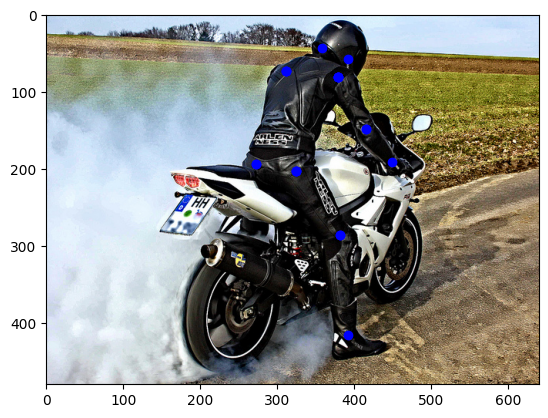

In [11]:
items = list(skeleton.merge(
    skeleton.confidence_map(), 
    skeleton.paf_field(), 
))
coco.results[6].plot_image_skeleton_keypoints(items, draw_skeleton=False)

## Model skeleton (model confidence, model paf)

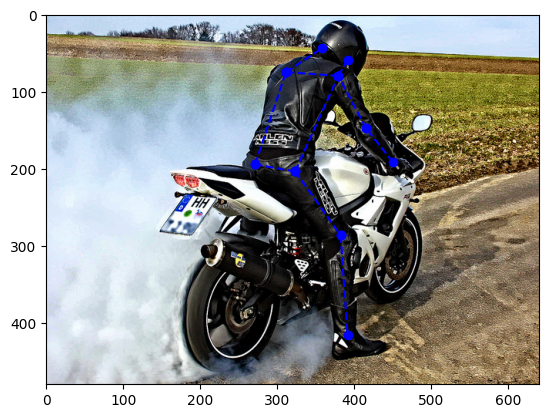

In [12]:
items = list(skeleton.merge(
    predicted_confidence, 
    predicted_paf,
))
coco.results[6].plot_image_skeleton_keypoints(items)

## True skeleton (coco)

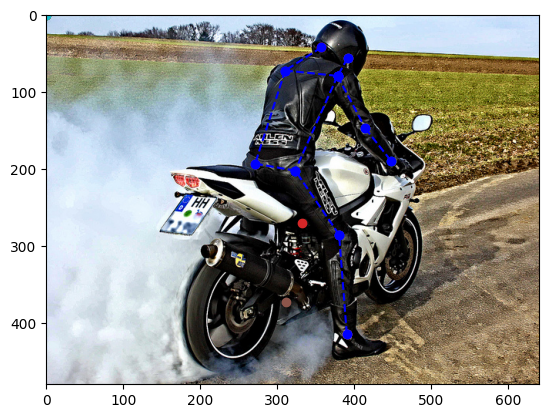

In [13]:
coco.results[6].imshow(
    skeleton=metadata_image['skeleton']
)